In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm

from IPython.display import clear_output

import os

In [2]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), title=""):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.title(title)
    plt.show()

In [3]:
class Generator(nn.Module):
    def __init__(self, n_dim=10, h_dim=128, im_dim=784):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            self.gen_block(n_dim, h_dim),
            self.gen_block(h_dim, h_dim*2),
            self.gen_block(h_dim*2, h_dim*4),
            self.gen_block(h_dim*4, h_dim*8),
            nn.Linear(h_dim*8, im_dim),
            nn.Sigmoid()
        )
    
    def gen_block(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.BatchNorm1d(out_dim),
            nn.LeakyReLU(negative_slope = 0.2, inplace = True)
        )

    def forward(self, noise):
        return self.gen(noise)

    def get_gen(self):
        return self.gen

In [4]:
class Discriminator(nn.Module):
    def __init__(self, h_dim=128, im_dim=784):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.disc_block(im_dim, h_dim*4),
            self.disc_block(h_dim*4, h_dim*2),
            self.disc_block(h_dim*2, h_dim),
            nn.Linear(h_dim, 1)
        )
    
    def disc_block(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.BatchNorm1d(out_dim),
            nn.LeakyReLU(negative_slope = 0.2, inplace = True)
        )

    def forward(self, image):
        return self.disc(image)

    def get_disc(self):
        return self.disc

In [5]:
def get_noise(batch_size, n_dim, device):
    return torch.randn(batch_size, n_dim, device=device)

def get_disc_loss(gen, disc, criterion, real, batch_size, n_dim, device):
    fake = gen(get_noise(batch_size, n_dim, device=device)).detach()
    y_fake = disc(fake)
    y_real = disc(real)
    fake_loss = criterion(y_fake, torch.zeros_like(y_fake))
    real_loss = criterion(y_real, torch.ones_like(y_real))
    disc_loss = ( fake_loss + real_loss ) / 2.0
    return disc_loss

def get_gen_loss(gen, disc, criterion, batch_size, n_dim, device):
    fake = gen(get_noise(batch_size, n_dim, device=device))
    y_fake = disc(fake)
    gen_loss = criterion(y_fake, torch.ones_like(y_fake))
    return gen_loss

In [6]:
criterion = nn.BCEWithLogitsLoss()
n_dim = 64
batch_size = 256
lr = 0.00001
device = 'mps'


dataloader = DataLoader(MNIST('.', download=True, transform=transforms.ToTensor()),
                        batch_size=batch_size, shuffle=True)

In [7]:
cur_step = 0
epoch_step = 0
sum_gen_loss = 0
sum_disc_loss = 0
mean_gen_loss = 0
mean_disc_loss = 0

gen = Generator(n_dim=n_dim).to(device)
disc = Discriminator().to(device)

gen_opt = optim.Adam(gen.parameters(), lr, weight_decay=0.001)
disc_opt = optim.Adam(disc.parameters(), lr, weight_decay=0.001)

Epoch 0: Generator loss: 0.6726694475796263, discriminator loss: 0.6963297376188181


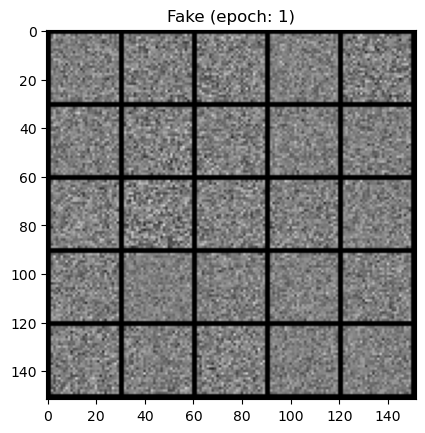

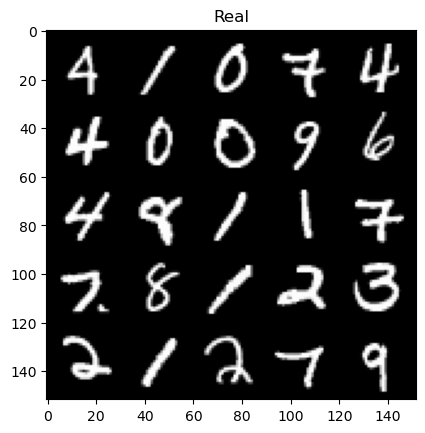

Epoch 1: Generator loss: 0.6898701574842808, discriminator loss: 0.6819826056391506
Epoch 2: Generator loss: 0.7084410513861704, discriminator loss: 0.6669193880032684
Epoch 3: Generator loss: 0.726412548352096, discriminator loss: 0.651595955177889
Epoch 4: Generator loss: 0.7414047480639765, discriminator loss: 0.6380572955487138


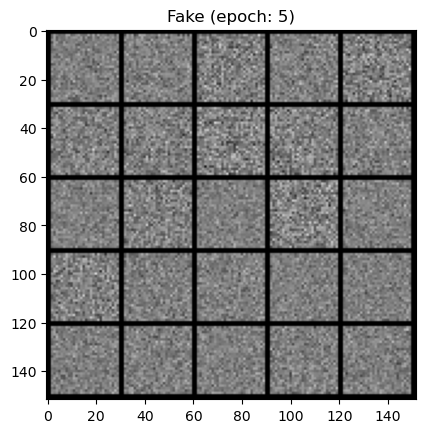

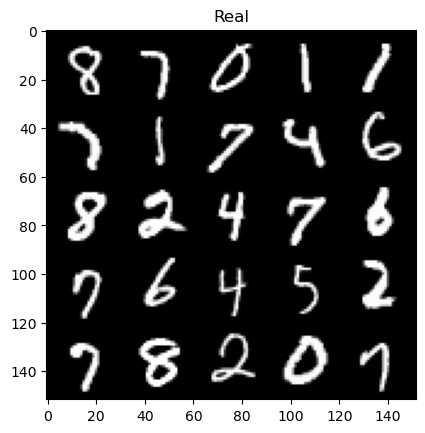

Epoch 5: Generator loss: 0.7500938773155212, discriminator loss: 0.6287868315890685
Epoch 6: Generator loss: 0.7502759255595126, discriminator loss: 0.6247286897594646
Epoch 7: Generator loss: 0.7468850011542693, discriminator loss: 0.6248628744634531
Epoch 8: Generator loss: 0.7410036123405068, discriminator loss: 0.6282310814170514
Epoch 9: Generator loss: 0.7377704159688141, discriminator loss: 0.6310361133793653


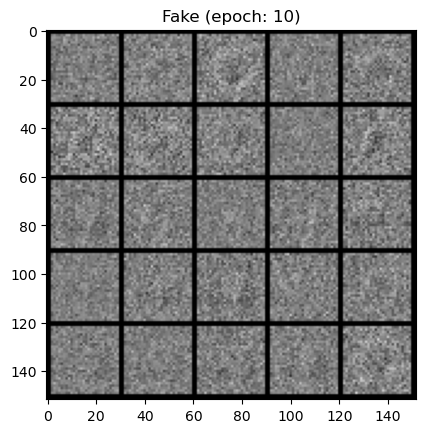

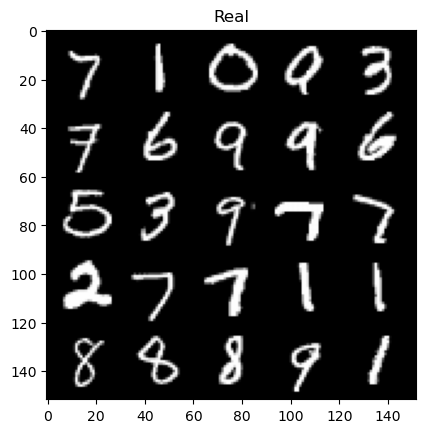

Epoch 10: Generator loss: 0.7438048654693669, discriminator loss: 0.629574505959527
Epoch 11: Generator loss: 0.7456779661825148, discriminator loss: 0.6281804093870066
Epoch 12: Generator loss: 0.748931297306287, discriminator loss: 0.6261667811264426
Epoch 13: Generator loss: 0.7550851177361052, discriminator loss: 0.622388519472995
Epoch 14: Generator loss: 0.7497288892834874, discriminator loss: 0.6241126974760476


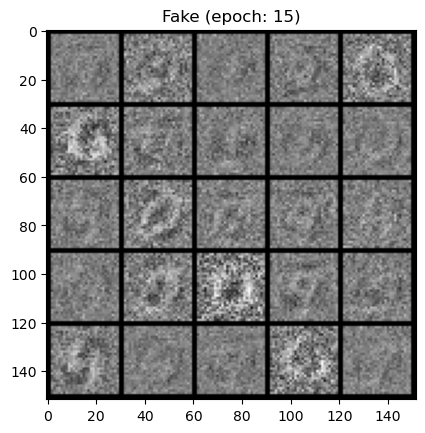

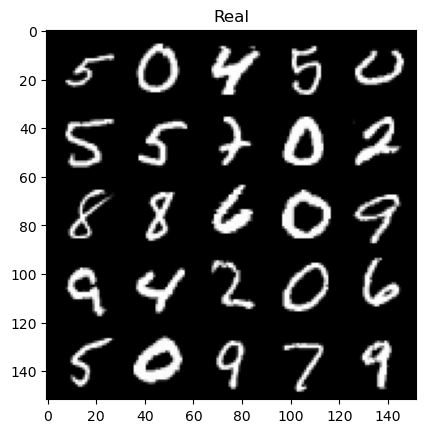

Epoch 15: Generator loss: 0.7579790257801444, discriminator loss: 0.6211812839669696
Epoch 16: Generator loss: 0.7596702227147959, discriminator loss: 0.6196350536103976
Epoch 17: Generator loss: 0.7585436423956338, discriminator loss: 0.6191215207011013
Epoch 18: Generator loss: 0.7647713498543884, discriminator loss: 0.6162516131239423


KeyboardInterrupt: 

In [8]:
clear_output()
num_epochs = 500
display_step = 5

for epoch in range(num_epochs):
    sum_gen_loss = 0
    sum_disc_loss = 0
    cur_step = 0

    for real, _ in dataloader:
        cur_batch_size = len(real)
        real = real.view(cur_batch_size, -1).to(device)
        
        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, n_dim, device)
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, n_dim, device)
        gen_loss.backward(retain_graph=True)
        gen_opt.step()

        sum_disc_loss += disc_loss.item() 
        sum_gen_loss += gen_loss.item() 

        cur_step += 1


    
    mean_disc_loss = sum_disc_loss/cur_step
    mean_gen_loss = sum_gen_loss/cur_step
    print(f"Epoch {epoch}: Generator loss: {mean_gen_loss}, discriminator loss: {mean_disc_loss}")
    torch.save(gen.state_dict(), 'generator_checkpoint.pth')
    
    epoch_step+=1
    if epoch_step % display_step ==0 or epoch_step==1:
        fake_noise = get_noise(cur_batch_size, n_dim, device=device)
        fake = gen(fake_noise)
        
        show_tensor_images(fake, title=f'Fake (epoch: {epoch_step})')
        show_tensor_images(real, title='Real')

torch.save(gen.state_dict(), 'generator.pth')
